In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = [i for i in range(10)]

Let us show some of the training images, for fun.



    1     7     4     3


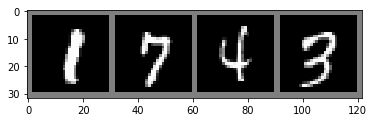

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [4]:
import torch.nn as nn
import torch.nn.functional as F

#from https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1  , 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


net = Net()

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [6]:
losses = []

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            
            losses.append(running_loss / 2000)
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.198
[1,  4000] loss: 0.546
[1,  6000] loss: 0.406
[1,  8000] loss: 0.390
[1, 10000] loss: 0.328
[1, 12000] loss: 0.317
[1, 14000] loss: 0.291
[2,  2000] loss: 0.261
[2,  4000] loss: 0.261
[2,  6000] loss: 0.261
[2,  8000] loss: 0.249
[2, 10000] loss: 0.237
[2, 12000] loss: 0.240
[2, 14000] loss: 0.240
[3,  2000] loss: 0.217
[3,  4000] loss: 0.225
[3,  6000] loss: 0.213
[3,  8000] loss: 0.208
[3, 10000] loss: 0.188
[3, 12000] loss: 0.202
[3, 14000] loss: 0.198
[4,  2000] loss: 0.192
[4,  4000] loss: 0.195
[4,  6000] loss: 0.190
[4,  8000] loss: 0.185
[4, 10000] loss: 0.184
[4, 12000] loss: 0.177
[4, 14000] loss: 0.198
[5,  2000] loss: 0.176
[5,  4000] loss: 0.191
[5,  6000] loss: 0.164
[5,  8000] loss: 0.172
[5, 10000] loss: 0.180
[5, 12000] loss: 0.185
[5, 14000] loss: 0.168
[6,  2000] loss: 0.171
[6,  4000] loss: 0.161
[6,  6000] loss: 0.173
[6,  8000] loss: 0.172
[6, 10000] loss: 0.162
[6, 12000] loss: 0.154
[6, 14000] loss: 0.182
[7,  2000] loss: 0.167
[7,  4000] 

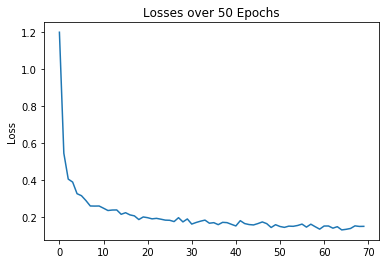

In [7]:
plt.plot(losses)
plt.title("Losses over 50 Epochs")
plt.ylabel('Loss')
plt.show()

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:      7     2     1     0


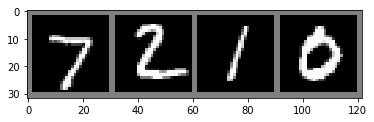

In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [9]:
outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [10]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:      7     2     1     0


In [11]:
correct = 0
total = 0
with torch.no_grad():
    with torch.enable_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 95 %


In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 96 %
Accuracy of     1 : 98 %
Accuracy of     2 : 91 %
Accuracy of     3 : 96 %
Accuracy of     4 : 95 %
Accuracy of     5 : 96 %
Accuracy of     6 : 95 %
Accuracy of     7 : 97 %
Accuracy of     8 : 94 %
Accuracy of     9 : 93 %


In [13]:
#save the model
torch.save(net, 'mnist_model.pt')

/Users/silver/anaconda3/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [14]:
model = torch.load('mnist_model.pt')

In [15]:
test_losses = []
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(testloader, 0):
        # get the inputs
        inputs, labels = data

       
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            
            test_losses.append(running_loss / 2000)
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.165
[2,  2000] loss: 0.158
Finished Training


# For BuildUCLA